In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, top_k_accuracy_score

import xgboost as xgb
import lightgbm as lgb
import pickle
import json


In [3]:
# Load train and test
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (750000, 10)
Test shape: (250000, 9)


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [ ]:
train.columns = [c.strip() for c in train.columns]
test.columns  = [c.strip() for c in test.columns]

def _find_col(cols, key):
    k = key.strip().lower().replace(" ", "")
    for c in cols:
        if c.strip().lower().replace(" ", "") == k:
            return c
    return None

t = _find_col(train.columns, "Fertilizer Name")
ID_COL = _find_col(train.columns, "ID_COL")

print("T:", t, "| ID_COL:", ID_COL)


TARGET: Fertilizer Name | ID: id


Missing values per column:
 id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64
Temparature: 0 potential outliers (IQR)
Humidity: 0 potential outliers (IQR)
Moisture: 0 potential outliers (IQR)
Nitrogen: 0 potential outliers (IQR)
Potassium: 0 potential outliers (IQR)
Phosphorous: 0 potential outliers (IQR)


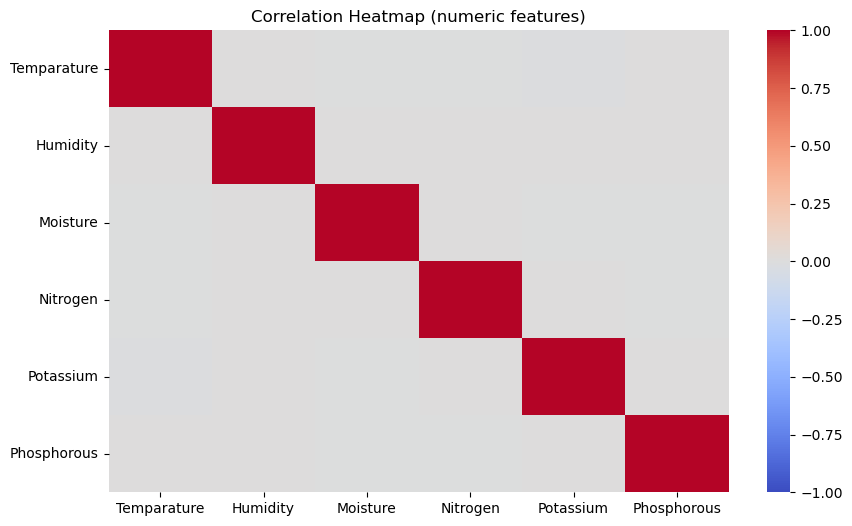

In [ ]:
# ADD as a new cell (EDA 1/2)
print("Missing values per column:\n", train.isnull().sum().sort_values(ascending=False))

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if ID_COL in numeric_cols:
    numeric_cols.remove(ID_COL)



In [8]:
# Outlier counts (IQR)
for col in numeric_cols:
    q1, q3 = train[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = ((train[col] < lo) | (train[col] > hi)).sum()
    print(f"{col}: {n_out} potential outliers (IQR)")


Temparature: 0 potential outliers (IQR)
Humidity: 0 potential outliers (IQR)
Moisture: 0 potential outliers (IQR)
Nitrogen: 0 potential outliers (IQR)
Potassium: 0 potential outliers (IQR)
Phosphorous: 0 potential outliers (IQR)


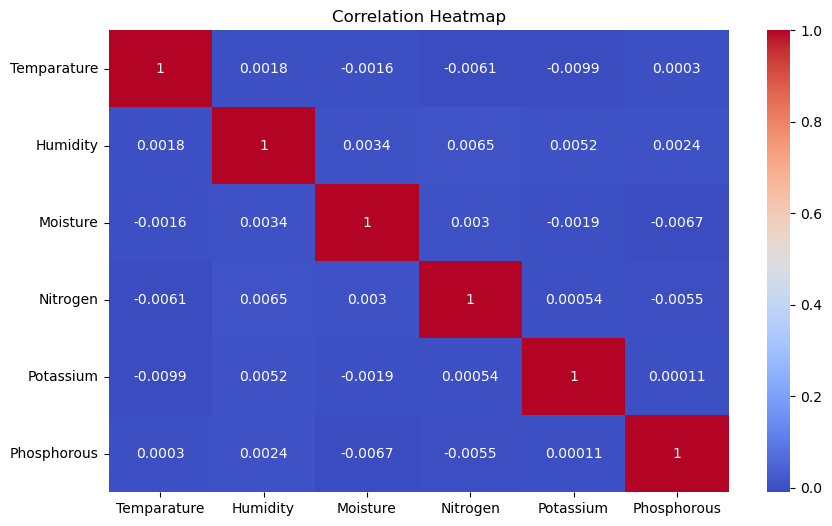

In [10]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

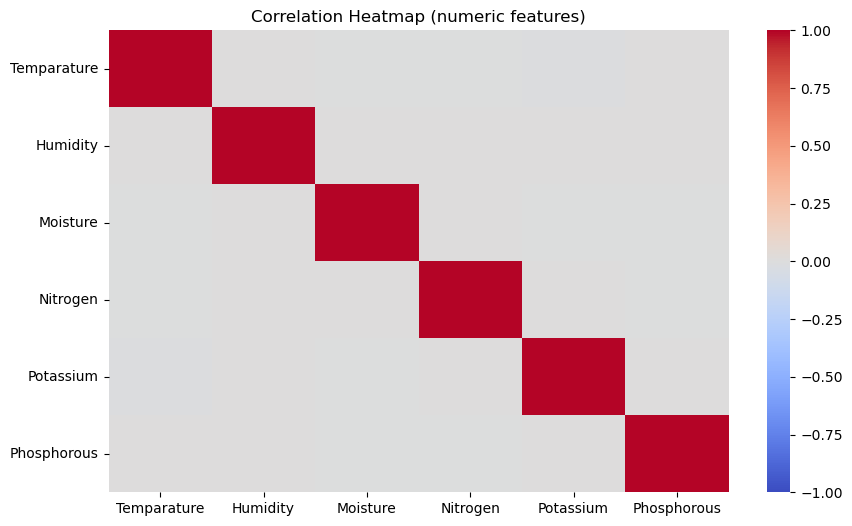

In [9]:
# Correlation heatmap (only if >=2 numeric columns)
if len(numeric_cols) >= 2:
    plt.figure(figsize=(10,6))
    corr = train[numeric_cols].corr()
    sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap (numeric features)")
    plt.show()

    # Report highly correlated pairs
    high_pairs = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            r = corr.iloc[i, j]
            if abs(r) > 0.8:
                high_pairs.append((numeric_cols[i], numeric_cols[j], float(r)))
    if high_pairs:
        print("Highly correlated pairs (|r|>0.8):", high_pairs)

In [11]:
# ADD as a new cell (EDA 2/2: VIF)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_vif = train[numeric_cols].copy().fillna(0)
    if X_vif.shape[1] >= 2:
        vif_df = pd.DataFrame({
            "feature": X_vif.columns,
            "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
        }).sort_values("VIF", ascending=False)
        print("VIF:\n", vif_df)
    else:
        print("VIF skipped: fewer than 2 numeric columns.")
except Exception as e:
    print("VIF skipped:", e)


VIF:
        feature        VIF
1     Humidity  43.681898
0  Temparature  39.821013
2     Moisture  14.336672
3     Nitrogen   5.111811
5  Phosphorous   3.845666
4    Potassium   3.641799


In [ ]:
feature_cols = [c for c in train.columns if c not in [ID_COL, t]]
cat_cols = train[feature_cols].select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in feature_cols if c not in cat_cols]

for c in cat_cols:
    train[c] = train[c].astype(str).str.strip()
    test[c]  = test[c].astype(str).str.strip()

target_le = LabelEncoder()
y = target_le.fit_transform(train[t])

label_encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train[c], test[c]], axis=0).astype(str).fillna("NA")
    le.fit(combined)
    train[c] = le.transform(train[c].astype(str).fillna("NA"))
    test[c]  = le.transform(test[c].astype(str).fillna("NA"))
    label_encoders[c] = le

X      = train[feature_cols].copy()
X_test = test[feature_cols].copy()

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)
with open("target_encoder.pkl", "wb") as f:
    pickle.dump(target_le, f)

schema = {
    "ID_COL": ID_COL,
    "target_col": t,
    "feature_cols": feature_cols,
    "categorical_cols": cat_cols,
    "numeric_cols": num_cols,
    "categorical_options": {c: sorted([str(v) for v in label_encoders[c].classes_.tolist()]) for c in cat_cols}
}
with open("schema.json", "w") as f:
    json.dump(schema, f, indent=2)

print("Saved encoders & schema: label_encoders.pkl, target_encoder.pkl, schema.json")


Saved encoders & schema: label_encoders.pkl, target_encoder.pkl, schema.json


In [ ]:
# --- Add training medians + target classes to the schema for the app ---

# 1) numeric medians (used by the app instead of 0.0)
num_medians = train[ [c for c in num_cols] ].median().to_dict()
num_medians = {k: float(v) for k, v in num_medians.items()}

# 2) target classes (used to map class ids -> fertilizer names)
# If you already have target_le fitted:
#   target_le = LabelEncoder()
#   y = target_le.fit_transform(train[TARGET])
target_classes = target_le.classes_.tolist()

# 3) update / write schema.json
schema = {
    "id_col": ID_COL,
    "target_col": TARGET,
    "feature_cols": feature_cols,
    "categorical_cols": cat_cols,
    "numeric_cols": num_cols,
    "categorical_options": {c: sorted([str(v) for v in label_encoders[c].classes_.tolist()]) for c in cat_cols},
    "numeric_medians": num_medians,
    "target_classes": target_classes
}
import json
with open("schema.json", "w") as f:
    json.dump(schema, f, indent=2)

print("Updated schema.json with numeric_medians and target_classes")


In [17]:
n_classes = len(np.unique(y))
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

preds_xgb = np.zeros((X_test.shape[0], n_classes))

best_model = None
best_logloss = float("inf")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n Fold {fold + 1}/3")

    X_tr, y_tr = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    xgb_model = xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        eval_metric="mlogloss",
        learning_rate=0.05,
        max_depth=6,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        verbosity=1,
        n_jobs=-1
    )

    # Train — keep your style; if early_stopping_rounds errors, remove it or use callbacks
    xgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    val_preds = xgb_model.predict_proba(X_val)
    fold_ll = log_loss(y_val, val_preds)
    print(f"Fold LogLoss: {fold_ll:.5f}")

    preds_xgb += xgb_model.predict_proba(X_test) / skf.n_splits

    # ADD ▼ keep best
    if fold_ll < best_logloss:
        best_logloss = fold_ll
        best_model = xgb_model

final_preds = preds_xgb

# ADD ▼ save best fold model for Flask
with open("fertilizer_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print(f"Saved best fold model with logloss={best_logloss:.5f} -> fertilizer_model.pkl")



 Fold 1/3
[0]	validation_0-mlogloss:1.94546


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-mlogloss:1.93107
[200]	validation_0-mlogloss:1.92598
[300]	validation_0-mlogloss:1.92277
[400]	validation_0-mlogloss:1.92065
[499]	validation_0-mlogloss:1.91915
Fold LogLoss: 1.91915

 Fold 2/3
[0]	validation_0-mlogloss:1.94547


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:01:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-mlogloss:1.93127
[200]	validation_0-mlogloss:1.92621
[300]	validation_0-mlogloss:1.92308
[400]	validation_0-mlogloss:1.92093
[499]	validation_0-mlogloss:1.91938
Fold LogLoss: 1.91938

 Fold 3/3
[0]	validation_0-mlogloss:1.94547


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-mlogloss:1.93127
[200]	validation_0-mlogloss:1.92619
[300]	validation_0-mlogloss:1.92303
[400]	validation_0-mlogloss:1.92084
[499]	validation_0-mlogloss:1.91932
Fold LogLoss: 1.91932
Saved best fold model with logloss=1.91915 -> fertilizer_model.pkl


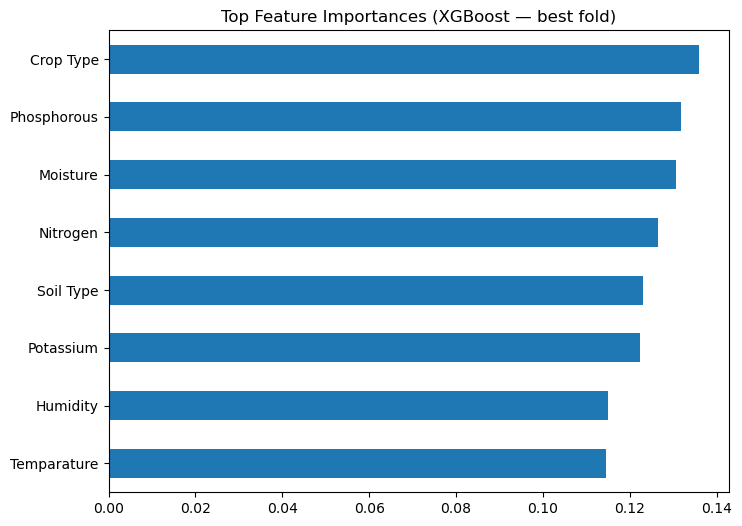

In [18]:
importances = best_model.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,6))
fi.head(20).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (XGBoost — best fold)")
plt.show()


In [ ]:
# final_preds: shape (N, n_classes)
# Get top-3 class indices per row
top3_idx = np.argsort(np.asarray(final_preds), axis=1)[:, ::-1][:, :3]  # (N, 3)

# Map indices -> original class names (works for 2D arrays)
top3_names = target_le.classes_[top3_idx]  # (N, 3) array of strings

# Join Top-3 per row into the space-delimited string required by the competition
pred_strings = [" ".join(row) for row in top3_names]

# Build and save submission
sub = pd.DataFrame({
    ID_COL: test[ID_COL].values,
    t: pred_strings
})
sub.to_csv("submission.csv", index=False)
print("Wrote submission.csv")


Wrote submission.csv
